<a href="https://colab.research.google.com/github/tommasomora01/StockIndexClassification/blob/main/StockIndexClassification_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install import-ipynb

In [49]:
import shutil
import os
directory = '/content/StockIndexClassification'

# Verifica se la directory esiste
if os.path.exists(directory):
    # Rimuovi la directory e il suo contenuto
    shutil.rmtree(directory)
    print(f'Directory "{directory}" rimossa.')
else:
    print(f'Directory "{directory}" non esiste.')
!git clone https://github.com/tommasomora01/StockIndexClassification.git
#%run /content/StockIndexClassification/StockIndexClassification_COLABnew.ipynb

Directory "/content/StockIndexClassification" rimossa.
Cloning into 'StockIndexClassification'...
remote: Enumerating objects: 911, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 911 (delta 154), reused 286 (delta 135), pack-reused 597 (from 1)
Receiving objects: 100% (911/911), 13.17 MiB | 22.26 MiB/s, done.
Resolving deltas: 100% (320/320), done.


In [50]:
import import_ipynb


In [51]:
from google.colab import drive
import os
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/StockPrediction'
config_file_path = '/content/drive/MyDrive/StockPrediction/config.json'
folders = ['/content/drive/MyDrive/StockPrediction/models_saved', '/content/drive/MyDrive/StockPrediction/log_saved']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader,Subset
import numpy as np
from sklearn.metrics import accuracy_score

import pandas as pd

import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
from typing import (Tuple)
import numpy as np
from StockIndexClassification.StockIndexClassification_COLABnew import load_config,DatasetHandler,SequenceDataset,TimeSeriesModel,EarlyStopping,train_model,evaluate_model

In [53]:

dataset = pd.read_excel("/content/drive/MyDrive/StockPrediction/model_data.xlsx", sheet_name="DATA")

config = load_config(config_file_path)

dataset = dataset.set_index('Data')

cleared_dataset = dataset.dropna()


In [54]:
from sklearn.preprocessing import MinMaxScaler
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the cleared dataset
normalized_dataset = scaler.fit_transform(cleared_dataset)
# Convert the normalized dataset back to a DataFrame
normalized_df = pd.DataFrame(normalized_dataset, columns=cleared_dataset.columns, index=cleared_dataset.index)

In [55]:

year_start = config['dataset_params']['year_start']
month_start = config['dataset_params']['month_start']
year_end = config['dataset_params']['year_end']
month_end = config['dataset_params']['month_end']

dataset_handler = DatasetHandler(normalized_df,year_start=year_start,month_start=month_start,year_end=year_end,month_end=month_end)
train_model_dataset , final_test = dataset_handler.split_dataset()

In [56]:
train_inputs = train_model_dataset.iloc[:,:]
#test_inputs = final_test.iloc[:,:]
folders[0] = os.path.join(folders[0],"dataset_2019_2022")
folders[1] = os.path.join(folders[1],"dataset_2019_2022")
print(type(train_inputs))
print(train_inputs.shape)


X_train_tensor = torch.tensor(train_inputs.to_numpy())

print(type(X_train_tensor))

<class 'pandas.core.frame.DataFrame'>
(1174, 14)
<class 'torch.Tensor'>


In [57]:
sequence_length = config['dataset_params']['sequence_length']
offset = config['dataset_params']['offset']
distance_pred = config['dataset_params']['distance_pred']
output_size = config['model_params']['output_size']
learning_rate = config['model_params']['learning_rate']
num_epochs = config['model_params']['num_epochs']
batch_size = config['model_params']['batch_size']

folders[0] = os.path.join(folders[0],f"{distance_pred}gg")
folders[1] = os.path.join(folders[1],f"{distance_pred}gg")

Num DOWN = 271, 25.711574952561673% (inf = -0.1) ;Num NEUTRAL = 376, 35.673624288425046%  ; Num UP = 407, 38.614800759013285% (sup = 10)


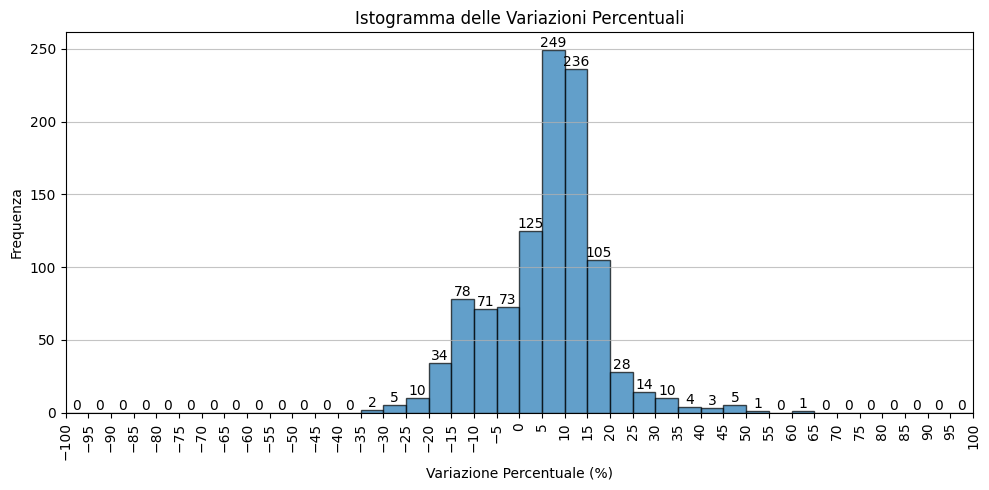

In [58]:
dataset = SequenceDataset(train_inputs, sequence_length=sequence_length, offset=offset,distance_pred=distance_pred)
#final_test_dataset = SequenceDataset(test_inputs, sequence_length=sequence_length, offset=offset,distance_pred=distance_pred)
dataset.show_sequence(plot_mode=True)
# Split train-test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# # Creazione dei DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
 #final_test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)
# for inputs in train_loader:
#   print(inputs[0].shape)
#   print(inputs[1].shape)
#   break
# for inputs in test_loader:
#     print(inputs[0].shape)
#     print(inputs[1].shape)
#     break

In [59]:
model_dim = config['model_params']['dimension']
d_model = config['model_params']['d_model']
n_head = config['model_params']['n_head']
dim_feedforward = config['model_params']['dim_feedforward']
num_layers = config['model_params']['num_layers']
kernel_size = config['model_params']['kernel_size']
early_stopping_patience = config['model_params']['early_stopping_patience']
early_stopping_delta = config['model_params']['early_stopping_delta']


In [60]:
# Creazione del modello
model = TimeSeriesModel(train_inputs.shape[-1], output_size,"small",d_model = d_model, n_head= n_head, dim_feedforward= dim_feedforward, num_layers=num_layers, kernel_size=kernel_size)

for m in model.modules():
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ReLU activation
    if isinstance(m, (nn.TransformerEncoderLayer)):
        nn.init.xavier_uniform_(m.linear1.weight)
        nn.init.xavier_uniform_(m.linear2.weight)
print(f"train_inputs.shape[-1] =  {train_inputs.shape[-1]}")
print(f"output_size =  {output_size}")

print(model)


train_inputs.shape[-1] =  14
output_size =  3
TimeSeriesModel(
  (conv1): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=same, padding_mode=reflect)
  (relu1): ReLU()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (relu2): ReLU()
  (classification_layer): Linear(in_features=32, out_features=3, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# # Definizione della loss e dell'optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(delta=early_stopping_delta, patience=early_stopping_patience)

In [62]:
for epoch in range(num_epochs):
        train_loss,stop = train_model(model, train_loader, test_loader, criterion, optimizer, device,early_stopping)
        #val_loss = evaluate_model(model, test_loader, device

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
        if stop:
            break
test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
print(f"Fold {1} - Accuracy: {test_accuracy:.4f}")

Epoch [1/1000], Loss: 1.0951
Epoch [2/1000], Loss: 1.0725
Epoch [3/1000], Loss: 1.0249
Epoch [4/1000], Loss: 0.9386
Epoch [5/1000], Loss: 0.8686
Epoch [6/1000], Loss: 0.8065
Epoch [7/1000], Loss: 0.7598
Epoch [8/1000], Loss: 0.7411
Epoch [9/1000], Loss: 0.7196
Epoch [10/1000], Loss: 0.6965
Epoch [11/1000], Loss: 0.6798
Epoch [12/1000], Loss: 0.6666
Epoch [13/1000], Loss: 0.6498
Epoch [14/1000], Loss: 0.6396
Epoch [15/1000], Loss: 0.6283
Epoch [16/1000], Loss: 0.6179
Epoch [17/1000], Loss: 0.6065
Epoch [18/1000], Loss: 0.5953
Epoch [19/1000], Loss: 0.5902
Epoch [20/1000], Loss: 0.5811
Epoch [21/1000], Loss: 0.5688
Epoch [22/1000], Loss: 0.5524
Epoch [23/1000], Loss: 0.5524
Epoch [24/1000], Loss: 0.5371
Epoch [25/1000], Loss: 0.5427
Epoch [26/1000], Loss: 0.5252
Epoch [27/1000], Loss: 0.5221
Epoch [28/1000], Loss: 0.5047
Epoch [29/1000], Loss: 0.5103
Epoch [30/1000], Loss: 0.4988
Epoch [31/1000], Loss: 0.4880
Epoch [32/1000], Loss: 0.4853
Epoch [33/1000], Loss: 0.4825
Epoch [34/1000], Lo

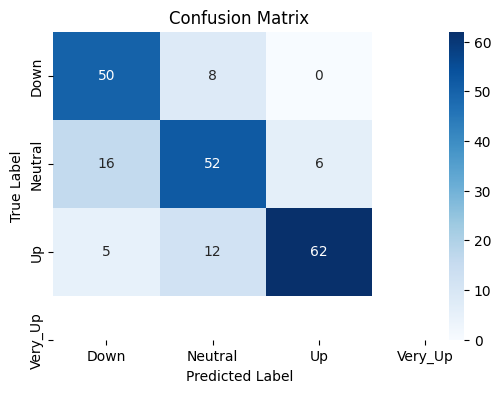

Matrice di Confusione:
[[50  8  0]
 [16 52  6]
 [ 5 12 62]]


In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# # Calcolare la matrice di confusione
cm = confusion_matrix(all_targets, all_predictions)

# Visualizzare la matrice di confusione
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Neutral', 'Up','Very_Up'], yticklabels=['Down', 'Neutral', 'Up','Very_Up'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Stampa la matrice di confusione
print("Matrice di Confusione:")
print(cm)

In [64]:

n_splits = 5
split_size = len(dataset) // n_splits
print(len(train_loader),split_size)
confusion_matrices = []
for split in range(1,n_splits):

    # Blocchi incrementali per training e testing
    train_indices = list(range(0, split * split_size))
    test_indices = list(range(split * split_size, (split + 1) * split_size))
    print(f"Train indices: {train_indices}")
    print(f"Test indices: {test_indices}")
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    # Training del modello
    early_stopping = EarlyStopping(delta=early_stopping_delta, patience=early_stopping_patience)
    model = TimeSeriesModel(train_inputs.shape[-1], output_size,model_dim,d_model = d_model, n_head= n_head, dim_feedforward= dim_feedforward, num_layers=num_layers, kernel_size=1)

    for m in model.modules():
        if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ReLU activation
        if isinstance(m, (nn.TransformerEncoderLayer)):
            nn.init.xavier_uniform_(m.linear1.weight)
            nn.init.xavier_uniform_(m.linear2.weight)
    for epoch in range(num_epochs):
        train_loss,stop = train_model(model, train_loader, test_loader, criterion, optimizer, device,early_stopping)
        #val_loss = evaluate_model(model, test_loader, device

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
        if stop:
            break
    test_accuracy, all_predictions, all_targets = evaluate_model(model, test_loader, device)
    print(f"Fold {split} - Accuracy: {test_accuracy:.4f}")

    # Calcolo e memorizzazione della matrice di confusione
    cm = confusion_matrix(all_targets, all_predictions)
    confusion_matrices.append(cm)

141 210
Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209]
Test indices: [210, 211, 212, 213, 2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/1000], Loss: 1.5601
Epoch [2/1000], Loss: 1.5660
Epoch [3/1000], Loss: 1.5599
Epoch [4/1000], Loss: 1.5686
Epoch [5/1000], Loss: 1.5592
Epoch [6/1000], Loss: 1.5722
all_predictions = 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
all_targets = 
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/1000], Loss: 1.2828
Epoch [2/1000], Loss: 1.2777
Epoch [3/1000], Loss: 1.2739
Epoch [4/1000], Loss: 1.2768
Epoch [5/1000], Loss: 1.2758
Epoch [6/1000], Loss: 1.2801
all_predictions = 
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
all_targets = 
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/1000], Loss: 1.4058
Epoch [2/1000], Loss: 1.4151
Epoch [3/1000], Loss: 1.4055
Epoch [4/1000], Loss: 1.4103
Epoch [5/1000], Loss: 1.4103
Epoch [6/1000], Loss: 1.4012
all_predictions = 
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
all_targets = 
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/1000], Loss: 1.1369
Epoch [2/1000], Loss: 1.1373
Epoch [3/1000], Loss: 1.1371
Epoch [4/1000], Loss: 1.1347
Epoch [5/1000], Loss: 1.1345
Epoch [6/1000], Loss: 1.1383
all_predictions = 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
all_targets = 
[2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [65]:
# final_test_accuracy, all_predictions_final, all_targets_final = evaluate_model(model, final_test_loader, device)
# print(f"Accuracy sul test set: {final_test_accuracy:.4f}")

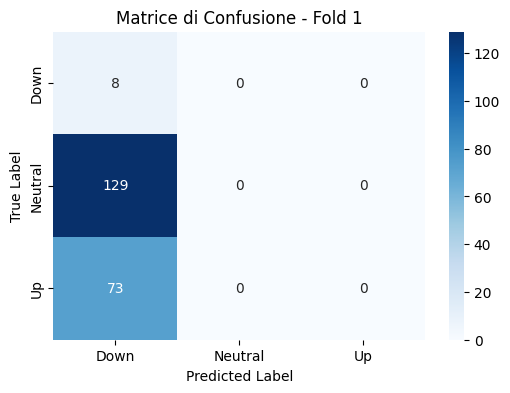

Matrice di Confusione per Fold 1:
[[  8   0   0]
 [129   0   0]
 [ 73   0   0]]


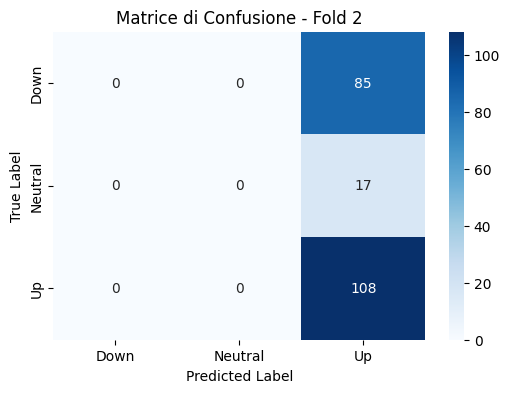

Matrice di Confusione per Fold 2:
[[  0   0  85]
 [  0   0  17]
 [  0   0 108]]


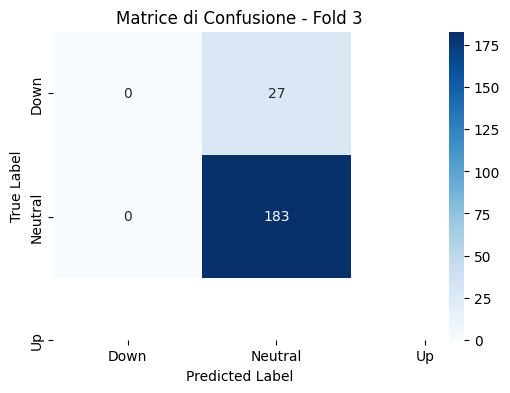

Matrice di Confusione per Fold 3:
[[  0  27]
 [  0 183]]


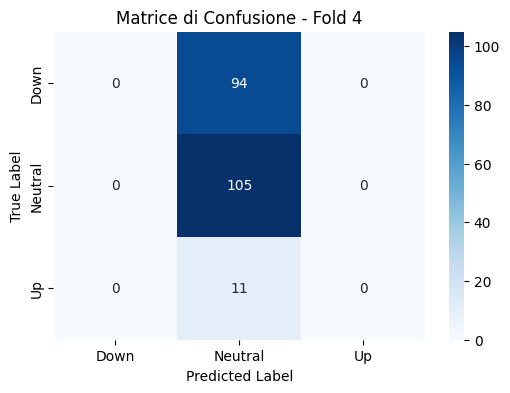

Matrice di Confusione per Fold 4:
[[  0  94   0]
 [  0 105   0]
 [  0  11   0]]


In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for i, cm in enumerate(confusion_matrices, start=1):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Down', 'Neutral', 'Up'], yticklabels=['Down', 'Neutral', 'Up'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Matrice di Confusione - Fold {i}')
    plt.show()
    print(f"Matrice di Confusione per Fold {i}:\n{cm}")

In [67]:
# cm = confusion_matrix(all_targets_final, all_predictions_final)

# # Visualizzare la matrice di confusione
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Neutral', 'Up'], yticklabels=['Down', 'Neutral', 'Up'])
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.title('Confusion Matrix')
# plt.show()

# # Stampa la matrice di confusione
# print("Matrice di Confusione:")
# print(cm)